In [1]:
from hashstash.profilers.engine_profiler import *
# logger.setLevel(logging.DEBUG)

In [230]:
c=HashStash()
func = c.profiler.profile
stash = func.stash
df = stash.df
df = df.reset_index().replace({'':np.nan})

# df['Num Proc'] = df['Num Proc'].apply(lambda x: f'{int(x):02}x')
df['Size (KB)'] = df['Raw Size (MB)'].apply(lambda x: int(x*1024))
df['Size (B)'] = df['Raw Size (MB)'].apply(lambda x: int(x*1024*1024))

import math

def group_by_magnitude(size_bytes):
    if size_bytes == 0:
        return '0 B'
    
    magnitude = int(math.log10(size_bytes))
    unit_index = magnitude // 3
    units = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    
    if unit_index >= len(units):
        return f'{size_bytes} B'  # Fallback for extremely large sizes
    
    unit = units[unit_index]
    # return unit
    scaled_size = size_bytes / (1024 ** unit_index)
    
    if magnitude % 3 == 0:
        return f'1 {unit}'
    elif magnitude % 3 == 1:
        return f'10 {unit}'
    else:
        return f'100 {unit}'

# Apply the function to create the new column
# df['Size Name'] = df['Size (B)'].apply(lambda x: 10**(round(math.log10(x))//1*1))
df['Size Name'] = df['Size (B)'].apply(lambda x: group_by_magnitude(x))
# df['Size Name'] = df['Size (B)'].apply(lambda x: x//1000*1000)
# df['Size Name'] = df['Size (B)'].apply(lambda x: "B" if x<1000 else "KB" if x<1000000 else "MB")
df['Size Name'].value_counts()
df=df[df['Size Name'].isin({'1 KB'})]

[24.29s] assembling all data from stash: 100%|██████████| 1420/1420 [00:19<00:00, 72.26it/s] 


Size Name
100 B     1542267
1 KB       945378
10 KB      762768
10 B        97992
1 B         52137
100 KB      21951
1 MB         9207
10 MB          18
Name: count, dtype: int64

In [247]:
@stashed_result
def get_speed_stats(group_by:list=None, operations:list=None, carry_over_cols:list=('Speed (MB/s)', 'Time (s)'), also_cols=('Raw Size (MB)',)):
    global df
    # df = df.reset_index().replace({'':np.nan})
    if operations:
        df = df[df['Operation'].isin(operations)]
    
    # Group by Engine and Operation, calculate median for numeric columns
    gby = ([] if not group_by else list(group_by)) + ['Operation']
    grouped = df.groupby(gby).median(numeric_only=True)
    
    # Reset index to make Operation a column
    grouped = grouped.reset_index()
    
    # Pivot the table to get speeds and carried over columns as separate columns
    pivot_values = list(carry_over_cols)
    pivoted = grouped.pivot(index=list(group_by)+list(also_cols), columns='Operation', values=pivot_values)
    
    # Flatten column names
    # pivoted.columns = [f'{col[1]} {col[0]}' if col[0] in carry_over_cols else f'{col[1]} (MB/s)' for col in pivoted.columns]
    pivoted.columns = [f'{col[1]} {col[0].split()[-1]}' for col in pivoted.columns]
    
    # Sort by Total speed descending
    odf = pivoted.reset_index()#.sort_values('Total (MB/s)', ascending=False)
    for c in odf:
        if c.endswith('(s)'):
            odf[f'{c.replace("(s)","(it/s)")}'] = 1/odf[c]
    odf['GetSet (s)'] = odf['Get (s)'] + odf['Set (s)']
    odf['GetSet (it/s)'] = 1/odf['GetSet (s)']
    return odf
get_speed_stats.stash.clear()

In [248]:

# Call the function and display results
get_speed_stats(group_by=['Engine','Size Name'])

,Engine,Size Name,Raw Size (MB),Decode (MB/s),Deserialize (MB/s),Encode (MB/s),Get (MB/s),Read (MB/s),Serialize (MB/s),Set (MB/s),...,Deserialize (it/s),Encode (it/s),Get (it/s),Read (it/s),Serialize (it/s),Set (it/s),Total (it/s),Write (it/s),GetSet (s),GetSet (it/s)
0,diskcache,1 B,0.000002,0.500000,0.210526,0.888889,0.000806,0.000810,0.242424,0.000500,...,99864.380952,466033.777778,388.361481,399.933635,116508.444444,224.240370,264.934087,287.399205,0.007034,142.158111
1,diskcache,1 KB,0.002419,199.857143,42.940285,262.588235,0.751749,0.780319,22.995205,0.408043,...,14074.845638,71089.898305,342.699894,371.506112,4236.670707,158.920299,158.165205,257.398220,0.009210,108.572124
2,diskcache,1 MB,3.181092,252.692740,191.104665,167.531824,784.927898,792.638663,227.920597,29.627956,...,51.803915,43.954854,223.267540,201.979389,89.151359,10.599734,10.427963,58.016516,0.098821,10.119314
3,diskcache,10 B,0.000051,10.143590,2.857143,9.023810,0.013469,0.014936,3.736232,0.009472,...,76260.072727,209715.200000,325.102042,395.894474,91180.521739,251.223623,250.152323,255.594394,0.007056,141.713822
4,diskcache,10 KB,0.017830,334.857143,63.198516,556.391304,5.312739,5.525164,40.485730,2.670496,...,3472.105960,23301.688889,316.145624,357.662147,2299.508772,154.611619,155.812029,244.181405,0.009631,103.832256
5,diskcache,100 B,0.000400,56.000000,6.044843,53.000000,0.107601,0.110481,1.947826,0.052597,...,17623.126050,167772.160000,335.544320,367.792354,6657.625397,133.013161,130.700321,263.362049,0.010498,95.253651
6,diskcache,100 KB,0.278702,272.748372,38.871410,271.402991,81.699910,84.932530,19.712133,4.677506,...,173.068042,808.774393,257.098443,279.201464,73.150511,16.720867,15.923403,170.358197,0.063695,15.699801
7,lmdb,1 B,0.000002,0.615385,0.210526,0.888889,0.042328,0.380952,0.242424,0.004571,...,99864.380952,262144.000000,20360.699029,190650.181818,113359.567568,2232.200106,5497.121887,10305.415233,0.000497,2011.656595
8,lmdb,1 KB,0.002439,192.137931,43.728814,73.503704,39.238095,380.965517,21.343284,1.976438,...,14217.979661,29330.797203,14926.348754,144631.172414,4185.932136,680.782990,801.357279,7476.477718,0.001536,651.087240
9,lmdb,1 MB,3.426444,246.585337,151.013375,35.082840,20901.659574,6763.195566,177.434712,26.875960,...,45.599678,22.185629,7570.945848,1945.410019,39.980783,8.621279,7.984557,282.654087,0.116124,8.611473


In [249]:
def plot_speed_comparison(df, group_by=['Engine'], x_col='Write', y_col='Read', color=None, log=False, facet=None):
    import plotnine as p9
    p9.options.figure_size = (8, 6)
    # Prepare the data
    if color and not color in group_by: group_by.append(color)
    if facet and not facet in group_by: group_by.append(facet)
    speed_df = get_speed_stats(group_by=group_by)
    speed_df = speed_df.reset_index()
    
    # Extract the specific operations we want to compare
    # cols = [*group_by]
    # if not x_col in cols: cols.append(x_col)
    # if not y_col in cols: cols.append(y_col)
    plot_df = speed_df #[cols]
    
    # Create a label column that combines all group_by columns
    plot_df['Label'] = plot_df[group_by].apply(lambda row: ' '.join(row.values[:1].astype(str)), axis=1)
    
    # Create the plot
    aes_params = {'x': x_col, 'y': y_col, 'label': 'Label'}
    if color:
        aes_params['color'] = color
    
    plot = (
        ggplot(plot_df, aes(**aes_params))
        # + geom_point(size=3)
        + geom_text(aes(label='Label'), size=8)
        + theme_classic()
        + labs(title=f'{y_col} vs {x_col} Speed Comparison')
            #    x=f'{x_operation} Speed (MB/s)',
            #    y=f'{y_operation} Speed (MB/s)')
    )

    if log:
        plot += scale_x_log10()
        plot += scale_y_log10()
        # plot += labs(x=f'{x_operation} Speed (MB/s) - Log Scale',
                    #  y=f'{y_operation} Speed (MB/s) - Log Scale')

    if facet:
        plot += facet_wrap(facet,ncol=2, scales='free')

    return plot

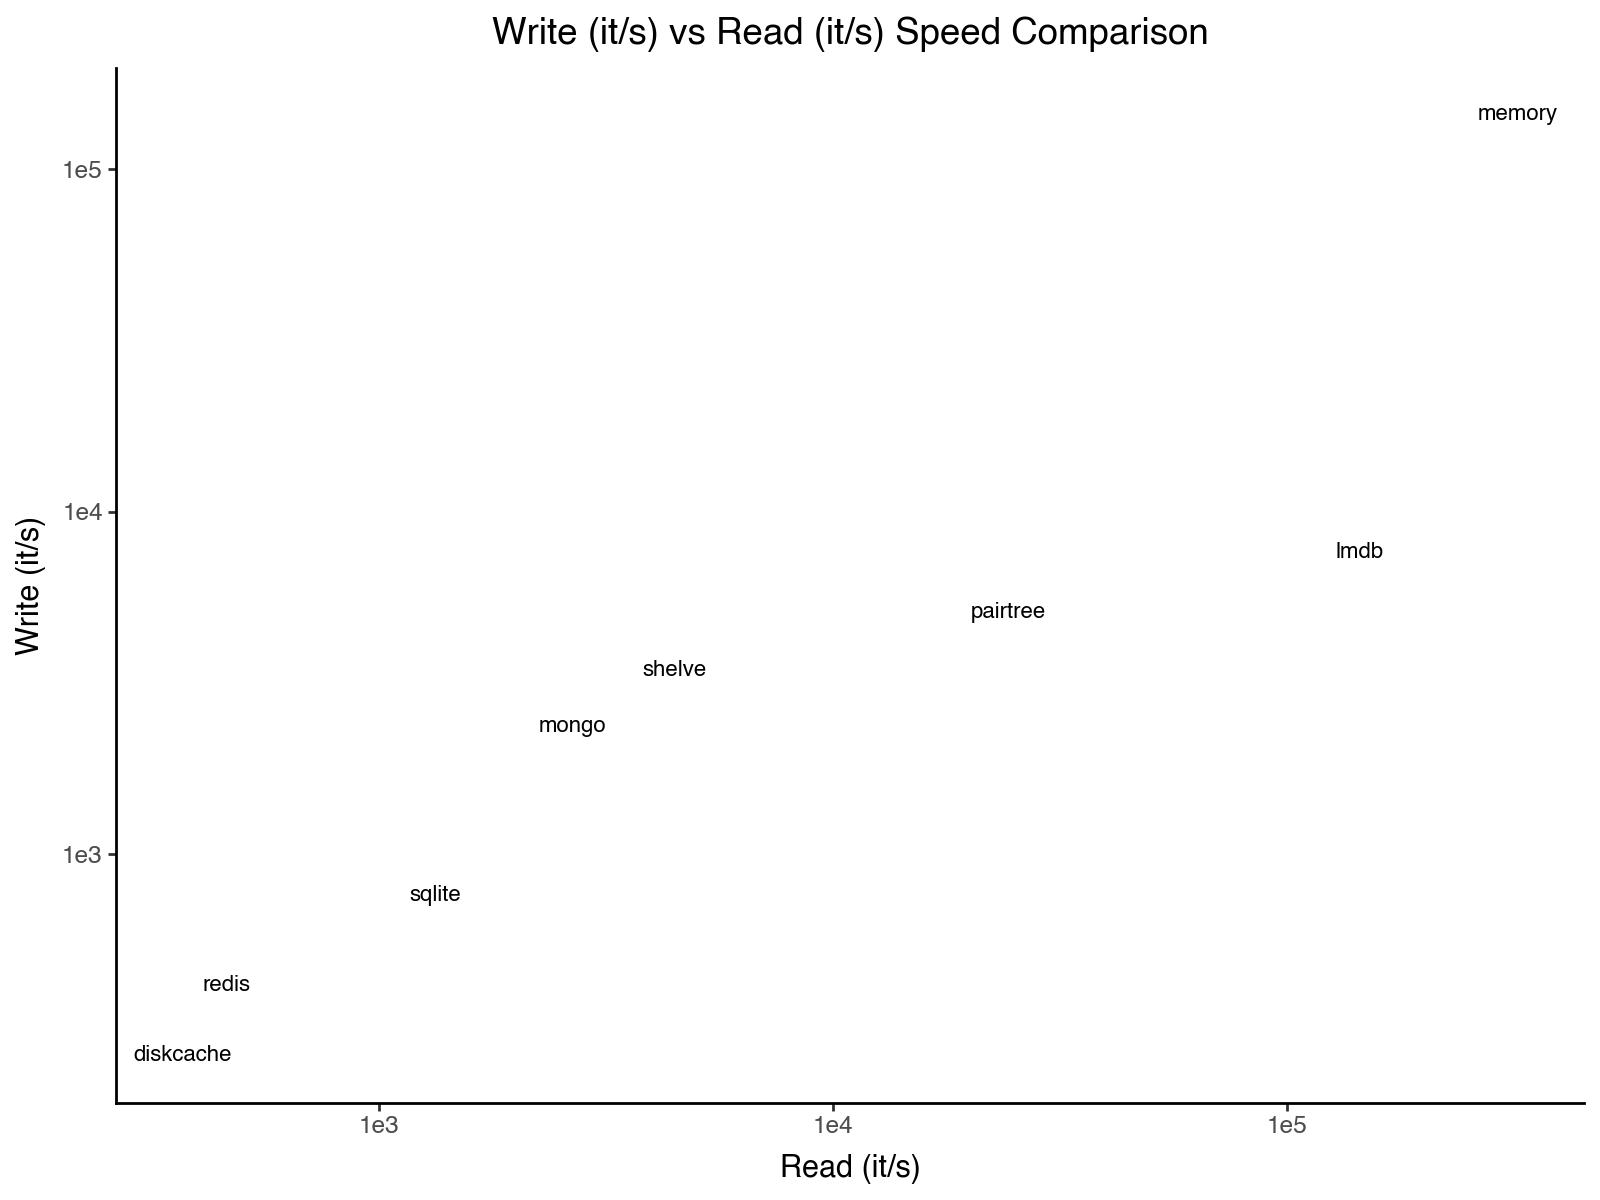

In [250]:
comparison_plot = plot_speed_comparison(df, group_by=['Engine'], x_col='Read (it/s)', y_col='Write (it/s)', log=True)
comparison_plot

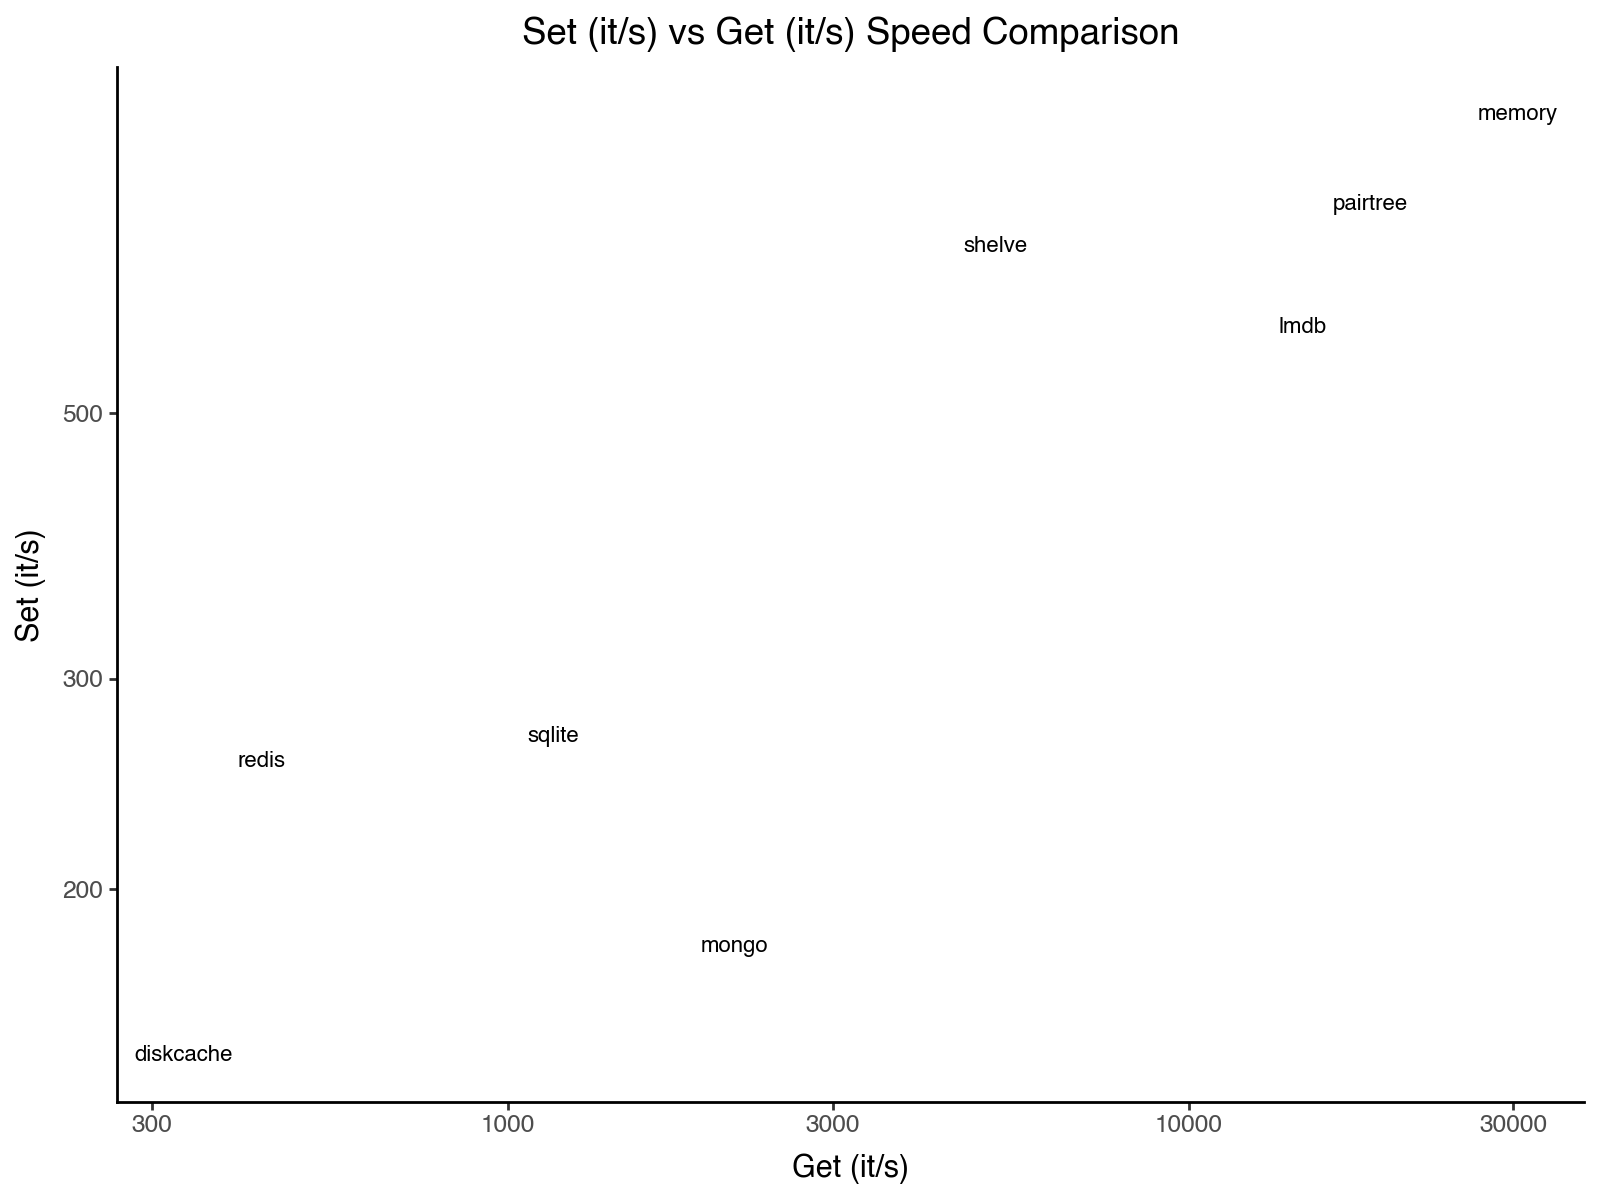

In [251]:
comparison_plot = plot_speed_comparison(df, group_by=['Engine'], x_col='Get (it/s)', y_col='Set (it/s)', log=True)
comparison_plot

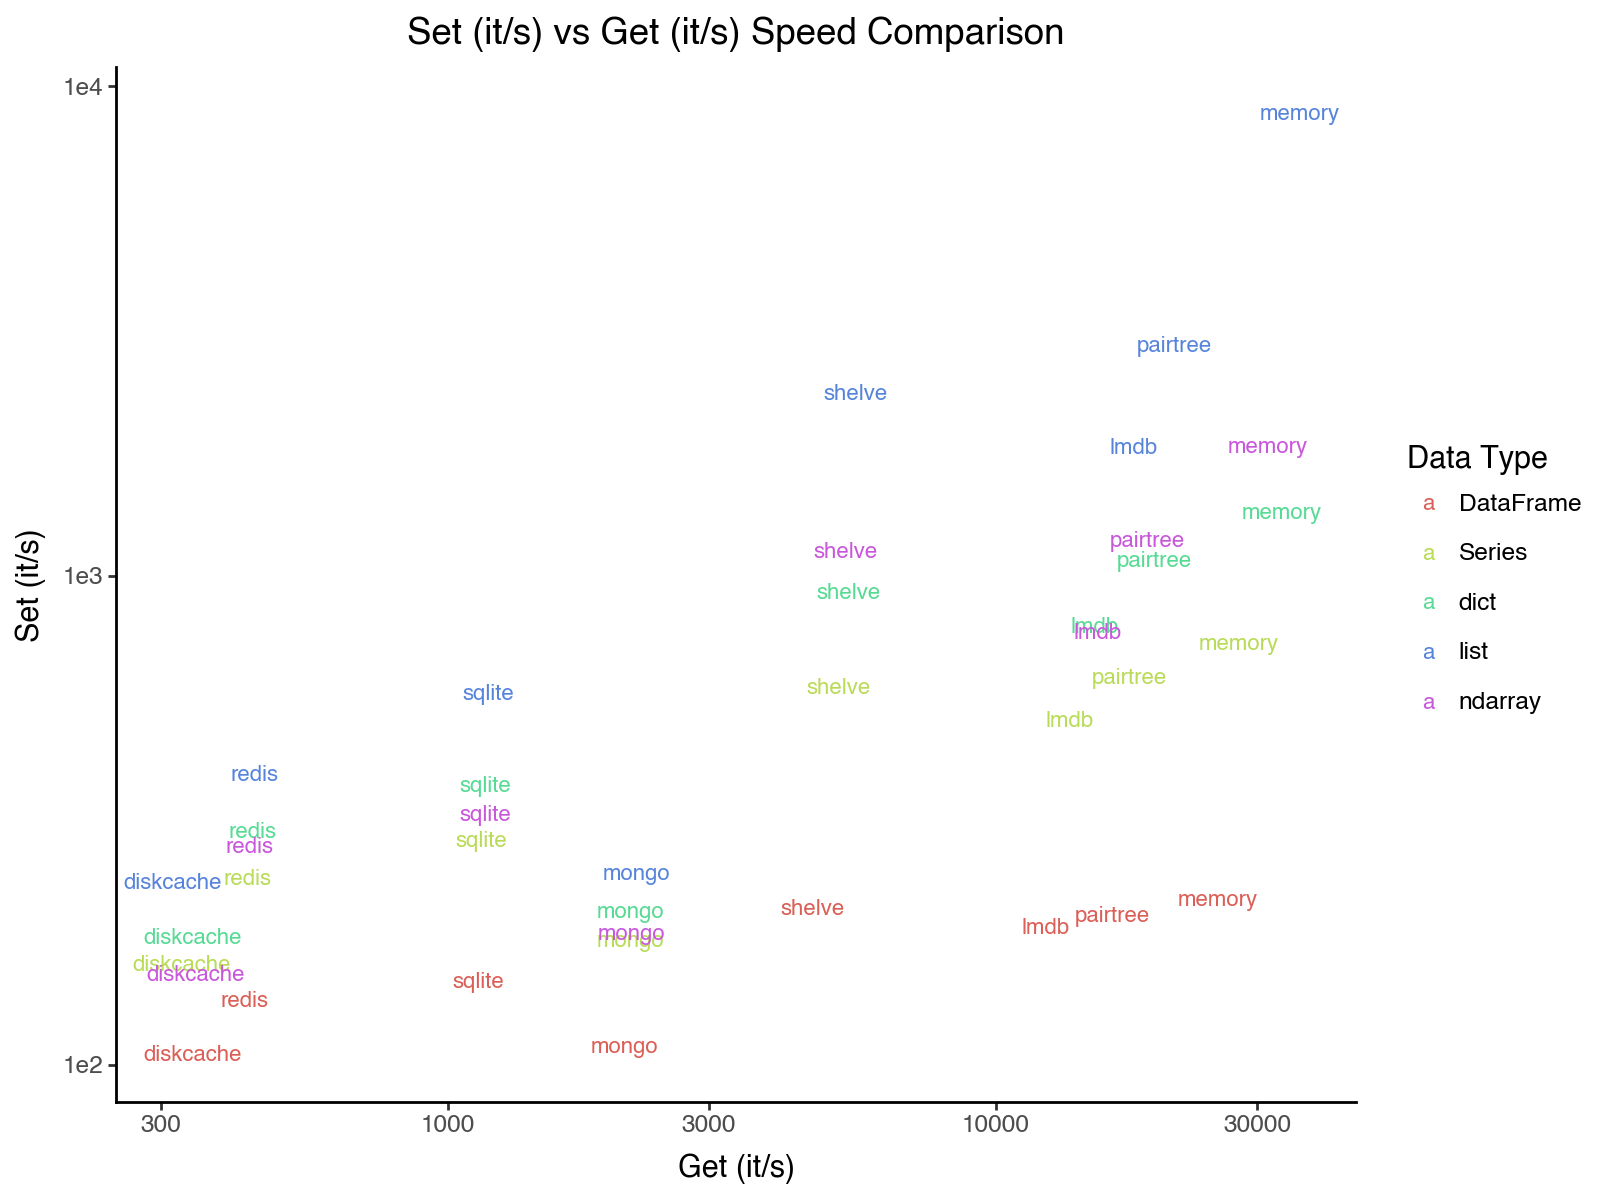

In [252]:
comparison_plot = plot_speed_comparison(df, group_by=['Engine'], x_col='Get (it/s)', y_col='Set (it/s)', log=True, color='Data Type')
comparison_plot


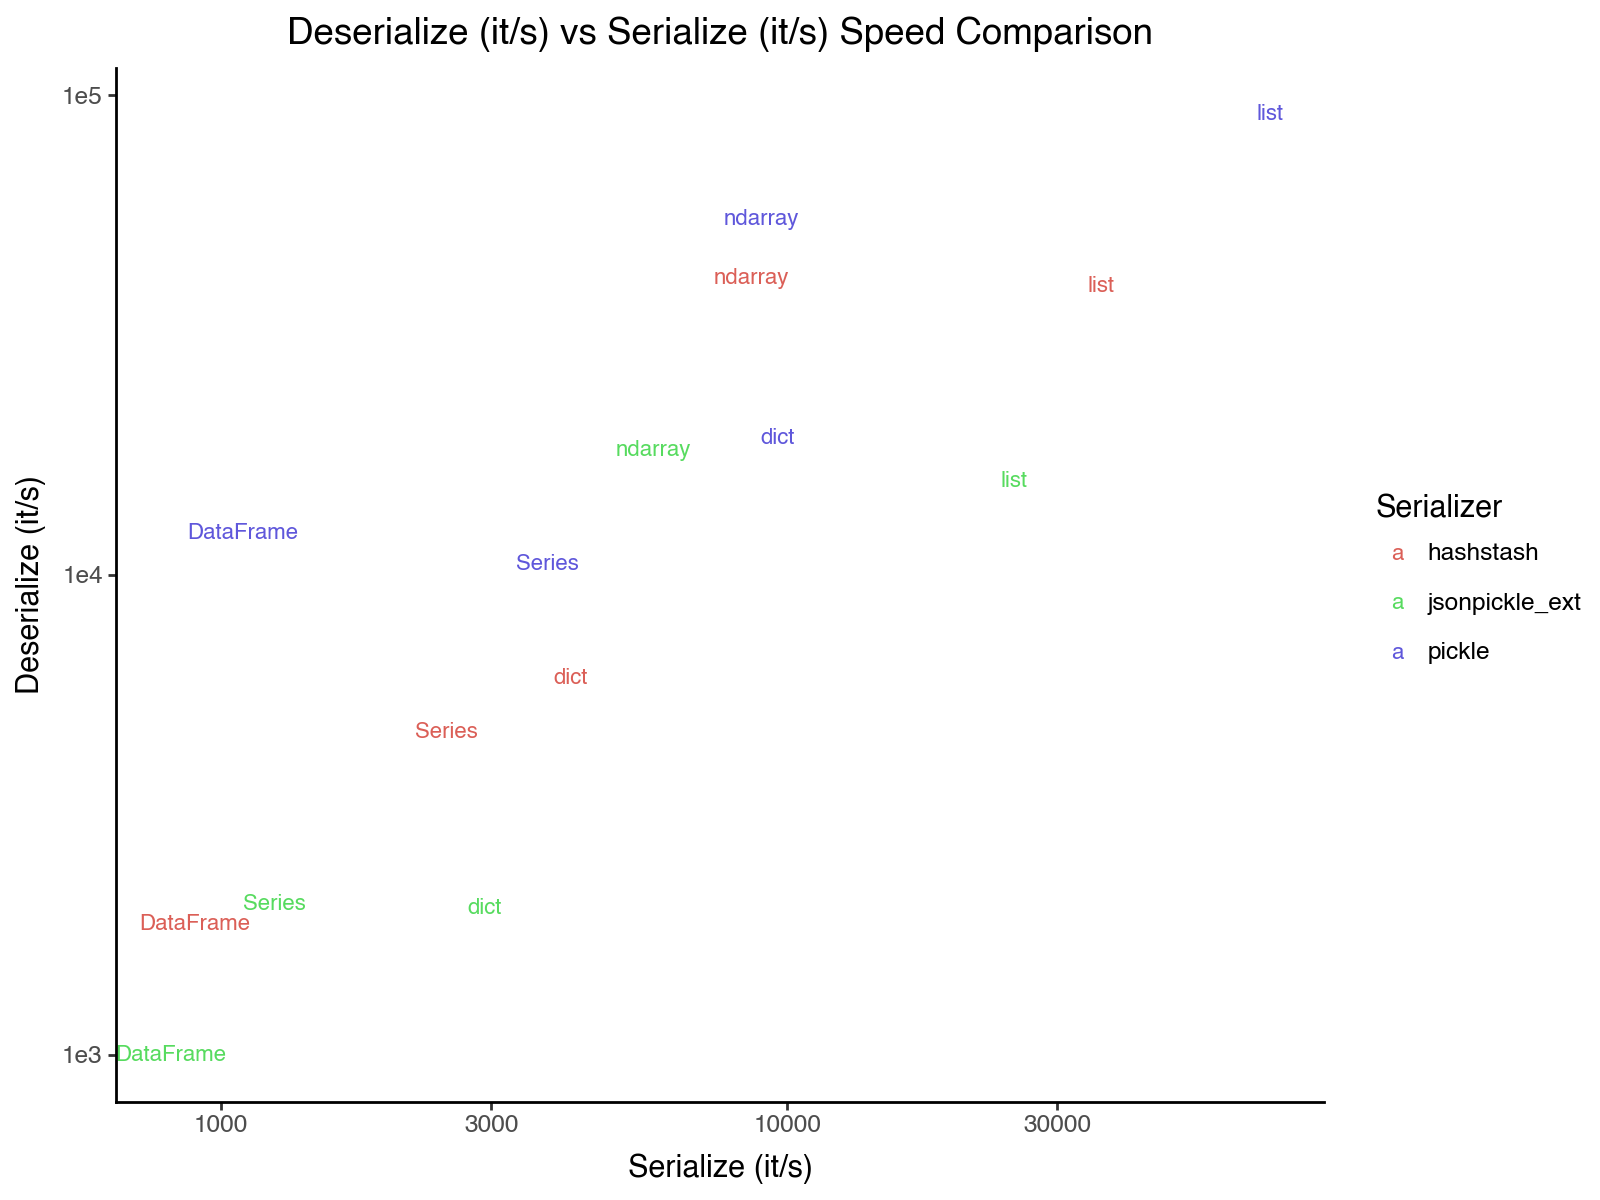

In [255]:
comparison_plot = plot_speed_comparison(df, group_by=['Data Type','Serializer'], x_col='Serialize (it/s)', y_col='Deserialize (it/s)',log=True, color='Serializer')
comparison_plot

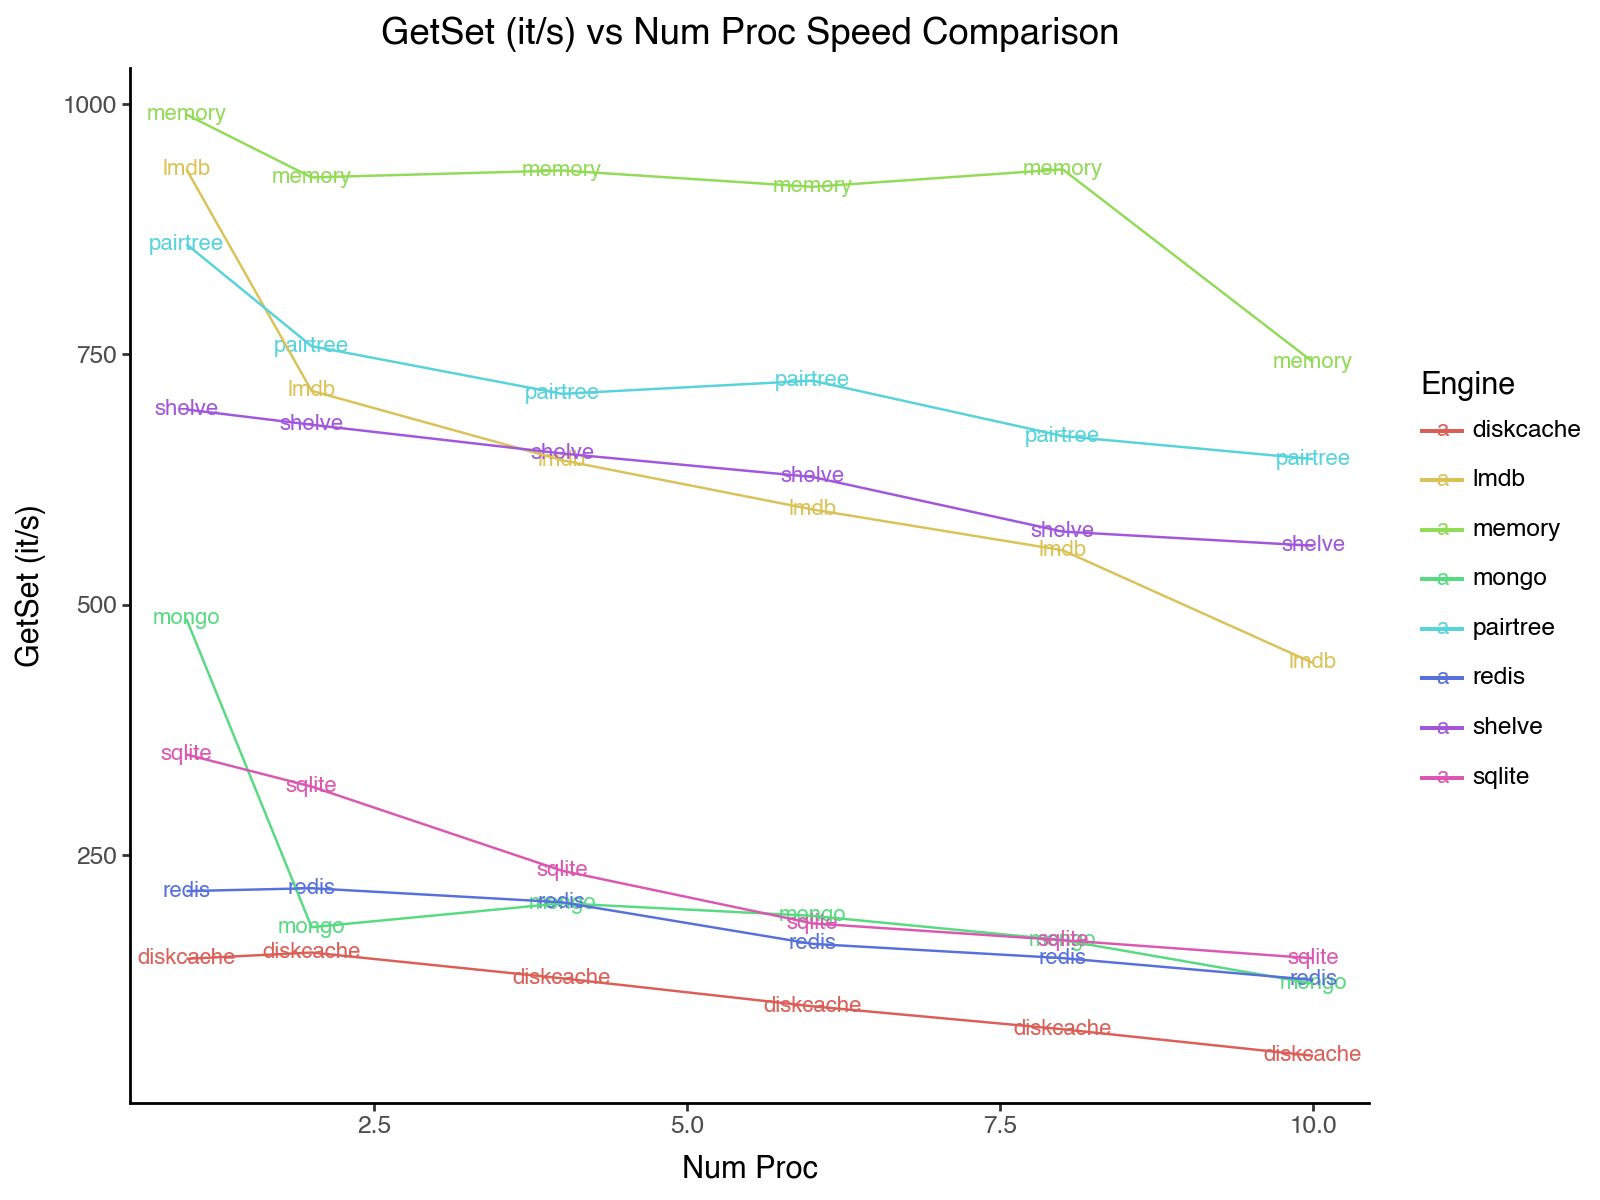

: 

In [259]:
import plotnine as p9
comparison_plot = plot_speed_comparison(df, group_by=['Engine','Num Proc'], x_col='Num Proc', y_col='GetSet (it/s)', log=False, color='Engine') + p9.geom_line()
comparison_plot


In [239]:
# import plotnine as p9
# comparison_plot = plot_speed_comparison(df, group_by=['Engine','Num Proc'], x_col='Num Proc', y_col='Total (MB/s)', log=False, color='Engine') + p9.geom_line()
# comparison_plot


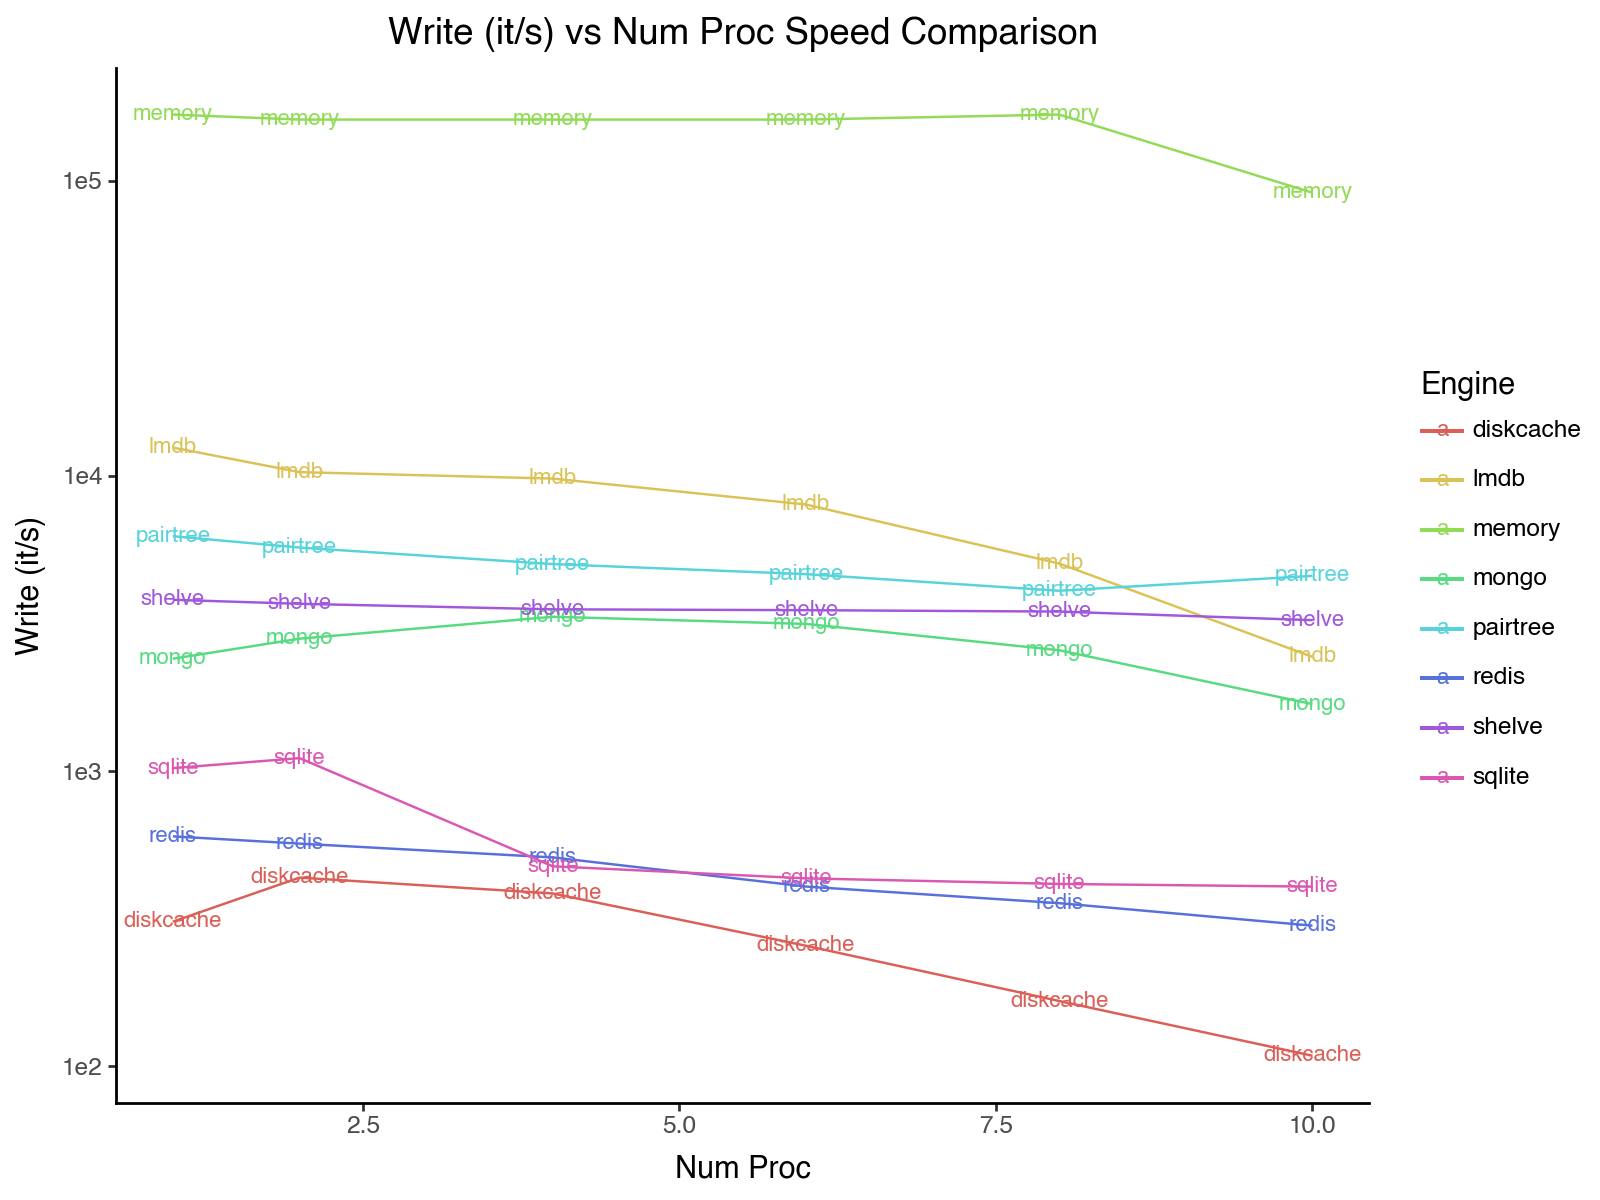

In [246]:
import plotnine as p9
comparison_plot = plot_speed_comparison(df, group_by=['Engine','Num Proc'], x_col='Num Proc', y_col='Write (it/s)', log=True, color='Engine') + p9.geom_line() + p9.scale_x_continuous()
comparison_plot


In [241]:
# import plotnine as p9
# comparison_plot = plot_speed_comparison(df[df.Serializer=='hashstash'], group_by=['Engine','Num Proc'], x_col='Num Proc', y_col='Set (MB/s)', log=True, color='Engine',facet='Size Name') + p9.geom_line()
# comparison_plot
